In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import math
import random

plt.style.use('dark_background')

In [2]:
def random_vec_on_circle(radius, num_vectors, seed=0):
    # Generate a sequence of angles
    np.random.seed(seed)
    angles = np.random.uniform(size=num_vectors)*2*np.pi
    # Compute the x- and y-coordinates of the vectors
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    # Stack the x- and y-coordinates into a single array of shape (num_vectors, 2)
    vectors = np.stack([x, y], axis=1)
    return vectors

In [178]:
from patbert.common import vis
import importlib
importlib.reload(vis)
class EmbeddingFigure():
    def __init__(self, num_vectors, num_sub_vectors, num_sub_sub_vectors,  len, sub_len, sub_sub_len, 
            num_sss_vecs=0, sss_len=0, s_vec=20, s_sub_vec=4, s_sub_sub_vec=.1, s_sss_vec=.01,
            modalities = ['Disease', 'Medicine', 'Lab Test', 'Procedure', 'SEP', 'CLS', 'MASK'], seed=0,
            figsize=(10,10), dpi=100, fontsize=12, save_path=None, marker_multiplier=8, axins_kwargs=None,
            zoom_sub_vec_num = 9):
        self.rng = np.random.default_rng(seed)
        self.num_vectors = num_vectors
        self.num_sub_vectors = num_sub_vectors
        self.num_sub_sub_vectors = num_sub_sub_vectors
        self.num_sss_vecs = num_sss_vecs
        self.len = len
        self.sub_len = sub_len
        self.sub_sub_len = sub_sub_len
        self.sss_len = sss_len
        self.modalities = modalities
        self.figsize = figsize
        self.dpi = dpi
        self.fontsize = fontsize
        self.save_path = save_path
        self.s_vec = s_vec
        self.s_sub_vec = s_sub_vec
        self.s_sub_sub_vec = s_sub_sub_vec
        self.s_sss_vec = s_sss_vec
        self.vecs = None
        self.sub_vecs = None
        self.sub_sub_vecs = None
        self.sss_vecs = None
        self.axins_kwargs = axins_kwargs
        self.default_colors = self.get_nice_colors_dark_background()
        self.sub_sub_vector_colors = None 
        self.sub_sub_vector_colors =  None 
        self.sss_vector_colors = None
        self.get_vector_colors()
        self.marker_multiplier = marker_multiplier
        self.axins = None
        self.zoom_sub_vec_num = zoom_sub_vec_num
    def __call__(self):
        assert len(self.modalities) == self.num_vectors, 'Number of modalities must match number of vectors'   
        self.default_colors = self.default_colors*5
        if self.num_sss_vecs > 0:
            self.vecs, self.sub_vecs, self.sub_sub_vecs, self.sss_vecs = self.get_vector_hierarchy()
        else:
            self.vecs, self.sub_vecs, self.sub_sub_vecs = self.get_vector_hierarchy()
        
        fig, ax = plt.subplots(figsize=self.figsize)
        self.scatter_vecs(ax)
        for i in range(self.num_vectors):
            ax.text(self.vecs[i,0]+0.1, self.vecs[i,1]+0.1, self.modalities[i], fontsize=self.fontsize, color='w')
        if self.zoom_sub_vec_num:
            self.reset_zoom_location()
        self.axins = vis.add_zoom_inset(ax,bbox_transform=ax.transAxes, **self.axins_kwargs)
        self.scatter_vecs(self.axins, marker_multiplier=self.marker_multiplier)
        # save figure
        if self.save_path:
            plt.savefig(self.save_path, dpi=self.dpi)
        return fig, ax, self.axins
    
    def reset_zoom_location(self):
        sub_vec_x = self.sub_vecs[self.zoom_sub_vec_num,0]
        sub_vec_y = self.sub_vecs[self.zoom_sub_vec_num,1]
        x_width = abs(self.axins_kwargs['xlim'][1] - self.axins_kwargs['xlim'][0])
        self.axins_kwargs['xlim'] = (sub_vec_x-x_width/2, sub_vec_x+x_width/2)
        y_width = abs(self.axins_kwargs['ylim'][1] - self.axins_kwargs['ylim'][0])
        self.axins_kwargs['ylim'] = (sub_vec_y-y_width/2, sub_vec_y+y_width/2)

    def get_vector_colors(self):
        self.sub_vector_color = np.repeat(self.default_colors, self.num_sub_vectors)
        self.sub_sub_vector_colors = np.repeat(self.default_colors, self.num_sub_vectors*self.num_sub_sub_vectors)
        if self.num_sss_vecs > 0:
            self.sss_vector_colors = np.repeat(self.default_colors, self.num_sub_vectors*self.num_sub_sub_vectors*self.num_sss_vecs)
        
    def scatter_vecs(self, ax, marker_multiplier=1):
        ax.scatter(self.vecs[:,0], self.vecs[:,1], s=self.s_vec*marker_multiplier, color=self.default_colors[:self.num_vectors])
        ax.scatter(self.sub_vecs[:,0], self.sub_vecs[:,1], s=self.s_sub_vec*marker_multiplier, color=self.sub_vector_color[:self.num_sub_vectors*self.num_vectors])
        ax.scatter(self.sub_sub_vecs[:,0], self.sub_sub_vecs[:,1], s=self.s_sub_sub_vec*marker_multiplier, 
            color=self.sub_sub_vector_colors[:self.num_sub_sub_vectors*self.num_sub_vectors*self.num_vectors])
        if self.num_sss_vecs > 0:
            ax.scatter(self.sss_vecs[:,0], self.sss_vecs[:,1], s=self.s_sss_vec*marker_multiplier, 
                color=self.sss_vector_colors[:self.num_sss_vecs*self.num_sub_sub_vectors*self.num_sub_vectors*self.num_vectors])

    def get_vector_hierarchy(self):
        all_vecs = []
        vectors = self.get_vec(self.num_vectors,self.len)
        sub_vec = []
        sub_sub_vec = []
        sss_vec = []
        for i in range(self.num_vectors):
            sub_vec.append(vectors[i] + self.get_vec(self.num_sub_vectors, self.sub_len))
            for j in range(self.num_sub_vectors):
                sub_sub_vec.append(sub_vec[i][j] + self.get_vec(self.num_sub_sub_vectors,self.sub_sub_len))
       
        sub_vec = np.concatenate(sub_vec, axis=0)
        sub_sub_vec = np.concatenate(sub_sub_vec, axis=0)
        if self.num_sss_vecs > 0:
            for k in range(len(sub_sub_vec)):
                sss_vec.append(sub_sub_vec[k] + self.get_vec(self.num_sss_vecs, self.sss_len))
        if self.num_sss_vecs > 0:
            sss_vec = np.concatenate(sss_vec, axis=0)
            return vectors, sub_vec, sub_sub_vec, sss_vec
        else:
            return vectors, sub_vec, sub_sub_vec
    def add_text(self, ax, level, vec_num, fontsize):
        if level='0':
            ax.text(self.vecs[vec_num])
    def get_vec(self, n, len):
        vec = self.rng.uniform(-1,1,(n,2))
        vec = len*vec/la.norm(vec, axis=1).reshape(-1,1)
        return vec
    @staticmethod
    def get_nice_colors_dark_background():
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        add_colors = ['#45bcde', '#52d273', '#e94f64', '#e57254']
        for color in add_colors:
            colors.insert(0, color)
        return  colors

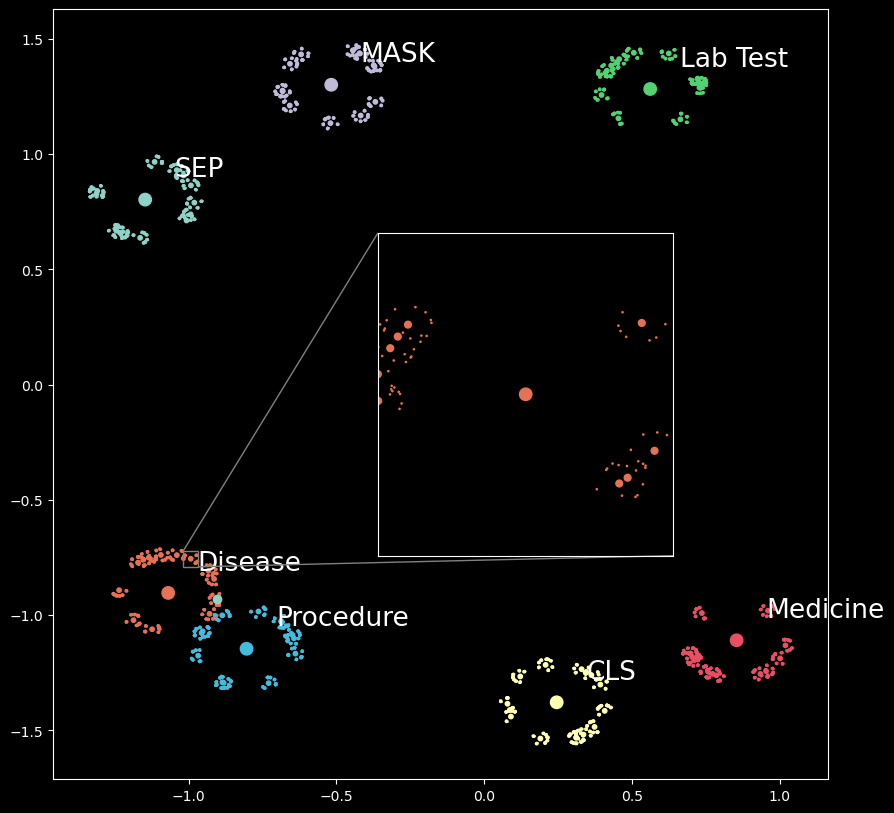

In [179]:
axins_kwargs = {'zoom':20, 'loc':7, 'x':-1, 'y':-1,
        'xlim':(-1.015,-.965), 'ylim':(-.79, -.72),
        'borderpad':0,
        'bbox_to_anchor':(.8, .5), 'mark_inset_loc':(4,2)}
embfig = EmbeddingFigure(num_vectors=7, num_sub_vectors=13, num_sub_sub_vectors=8, 
                len=1.4, sub_len=1/6, sub_sub_len=1/40, seed=2, fontsize=19,
                num_sss_vecs=7, sss_len=1/250,s_vec=80, s_sub_vec=10, s_sub_sub_vec=3, s_sss_vec=.1,axins_kwargs=axins_kwargs, 
                zoom_sub_vec_num=9)
fig, ax, axins = embfig()
subvec_num = 12
ax.scatter(embfig.sub_vecs[subvec_num,0], embfig.sub_vecs[subvec_num,1])
# Create the inset axis and plot the zoomed-in data

In [31]:
num_vecs = 3
vec0 = np.array([[0,0],[-1,1],[1,1], [np.sqrt(2), np.sqrt(2)]])#produc_vec(num_vecs, 15)
vec1_ls = []
vec2_ls = []
n1, n2 = 6, 4
for i in range(n1):
    vec1_ls.append(vec0 + produce_vec(len(vec0), .4) ) 
vec1 = np.concatenate(vec1_ls, axis=0)
for i in range(n2):
    vec2_ls.append(vec1 + produce_vec(len(vec1), .05) ) 
vec2 = np.concatenate(vec2_ls, axis=0)

In [32]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = default_colors[1:num_vecs+1]
colors1 = default_colors*n1#colors1.tolist()
colors2 = default_colors*(n1*n2)

ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 4.

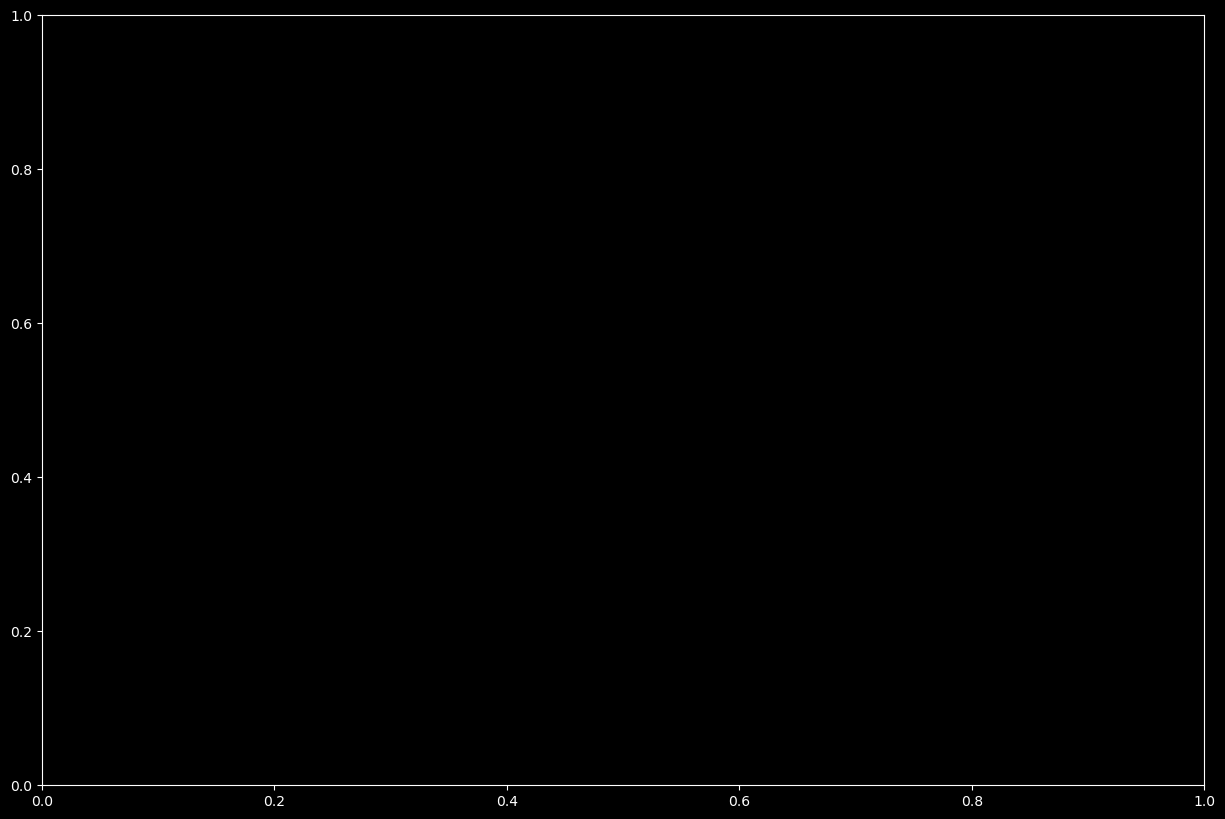

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(vec0[:,0], vec0[:,1], s=100, c=default_colors)
ax.scatter(vec1[:,0], vec1[:,1], s=20, c=colors1)
ax.scatter(vec2[:,0], vec2[:,1], s=1, c=colors2)
# annotate vec0
ax.annotate('Diseases', (vec0[2,0]+.1, vec0[2,1]), fontsize=20, color=default_colors[2])
ax.annotate('Neoplasm', (vec1[8,0]-.1, vec1[8,1]+.1), fontsize=14, color=default_colors[2])
ax.annotate('in situ', (vec2[8,0]+.01, vec2[8,1]-.1), fontsize=10, color=default_colors[2])

ax.annotate('Medication', (vec0[1,0], vec0[1,1]+.1), fontsize=20, color=default_colors[1])
ax.annotate('Cardiovascular', (vec1[7,0]-.24, vec1[7,1]-.16), fontsize=14, color=default_colors[1])
ax.annotate('diuretics', (vec2[7,0]-.16, vec2[7,1]+.05), fontsize=10, color=default_colors[1])

# origin = np.array([[0, 0],[ .5, .5]]) # origin point
# V = np.array([[1.7, -.8], [1.7*2, -.8*2]]) # vectors
# ax.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=10)

plt.axis('off')